# Model initialization and selection procedure

## Model initialization

Start with loading the required packages.

In [1]:
from conflict_model import utils, selection, plots

import matplotlib.pyplot as plt
import numpy as np
import os, sys
import warnings
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.5b
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.22.1
matplotlib version: 3.2.1
seaborn version: 0.10.1
rasterstats version: 0.14.0


In the cfg-file, all the settings for the analysis are defined. By 'parsing' (i.e. reading) it, all settings and file paths are known to the model. This is a simple way to make the code independent of the input data and settings.

In [3]:
settings_file = 'example_settings.cfg'

Based on this cfg-file, the set-up of the run can be initialized. One part of the cfg-file is the specification and creation of an output folder.

In [4]:
config, out_dir = utils.initiate_setup(settings_file)

saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\example\OUT

no conflict file was specified, hence downloading data from http://ucdp.uu.se/downloads/ged/ged201-csv.zip to C:\Users\hoch0001\Documents\_code\conflict_model\example\example_data\UCDP\ged201-csv.zip



## Filter conflicts and polygons

As conflict database, we use the [PRIO/UCDP database](https://ucdp.uu.se/downloads/). Not all conflicts of the database may need to be used in the model. This can be, for example, because they belong to a non-relevant type of conflict we are not interested in, or because it is simply not in our area-of-interest.

In the selection procedure, we first load the conflict database and convert it to a georeferenced dataframe (geo-dataframe). We then only keep those entries that fit to our selection criteria as specified in the cfg-file. Subsequently, we clip the remaining conflict datapoints to the extent of a provided shp-file, representing the area-of-interest. Here, we focus on the African continent and do the analysis at the scale of water provinces. The remaining conflict points are then used for the machine-learning model.

In [5]:
conflict_gdf, extent_gdf, selected_polygons_gdf, global_df = selection.select(config, out_dir)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\example\example_data\UCDP\ged201.csv

translating to geopandas dataframe

filtering on conflict properties...
...filtering key best with lower value 1
...filtering key type_of_violence with value(s) ['1', '2', '3']
focussing on period between 2000 and 2015
reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\example\example_data\waterProvinces/waterProvinces_Africa.shp

fixing invalid geometries

clipping clipping conflict dataset to extent

clipping conflicts to climate zones ['BWh', 'BSh']

clipping polygons to climate zones ['BWh', 'BSh']



Depending on the settings, we may focus on some climate zones only. As such, not all water provinces are used in the model. For a visual inspection if this selection worked as intended, we plot below the conflicts and as background map only those water provinces that are actually used in the model.

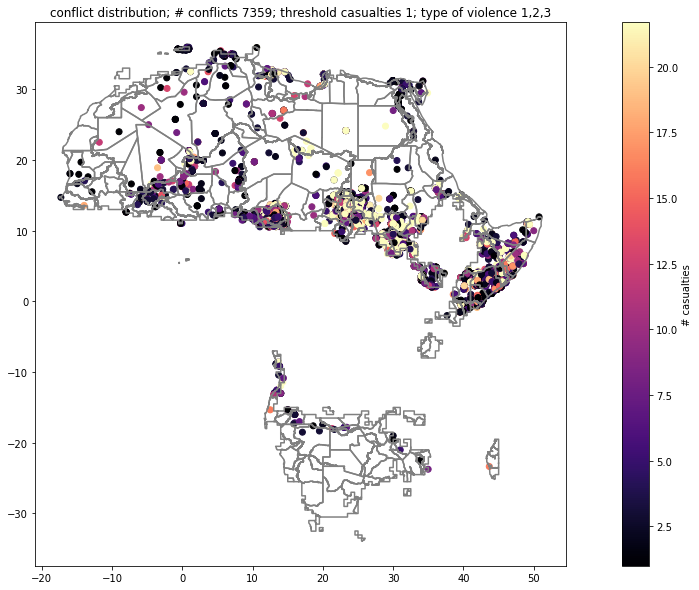

In [6]:
ax = plots.selected_polygons(selected_polygons_gdf, color='0.5', figsize=(20, 10))
plots.selected_conflicts(conflict_gdf, ax=ax, cmap='magma', vmin=1, vmax=conflict_gdf.best.mean(), 
                         legend=True, legend_kwds={'label': "# casualties", 'orientation': "vertical"})
ax.set_title('conflict distribution; # conflicts {}; threshold casualties {}; type of violence {}'.format(len(conflict_gdf), config.get('conflict', 'min_nr_casualties'), config.get('conflict', 'type_of_violence')));

The selected conflict points and polygons are saved as shp-files to be re-used later. For the dataframe with polygon ID and geometry we need to take a detour via numpy because the more straighforwad option to store the dataframe as csv does not with geometry information.

In [7]:
global_df['ID'] = global_df.index.values
global_arr = global_df.to_numpy()
np.save(os.path.join(out_dir, 'global_df'), global_arr)